# Code tutorials for Runge-Kutta Methods

$\newcommand{mb}[1]{\mathbf{#1}}$
If you want to have a nicer theme for your jupyter notebook, download the cascade stylesheet file calculus4N.css and execute the next cell:

In [1]:
from IPython.core.display import HTML
def css_styling():
    try:
        fname = "calculus4N.css"
        with open(fname, "r") as f:
            styles = f.read()
            return HTML(styles)
    except FileNotFoundError:
        print(f"Could not find css file '{fname}'")

# Comment out next line and execute this cell to restore the default notebook style 
css_styling()

As always, we start by calling the necessary modules: And of course we want to import the required modules.

In [2]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import interact, fixed
import numpy as np
from numpy import pi
from numpy.linalg import solve, norm    
import matplotlib.pyplot as plt

# Use a funny plotting style
plt.xkcd()

newparams = {'figure.figsize': (6.0, 6.0),
             'axes.grid': True,
             'lines.markersize': 8, 
             'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

## Code tutorial 1: Implementation of explicit RKM

### Some programming basics: classes in Python

## Plan
Start from simplest dog class to explain 
  * class vs instance variables, special `__init__` function, 
  * meaning of `self` argument, 
  * add bark/fetch stick functions
  * Write ExplicitRungeKutta class with a `solve` function
  * Introduce special class function `__call__`

In [ ]:
# Let's develop a simple dog class

In [3]:
class Dog:
    
    race = "Boxer"
    
    def __init__(self, name_str, speed):
        self.name  = name_str
        self.speed = speed
    
    def fetch_stick(self, length):
        t = length/self.speed
        return t

asta = Dog("Asta", 5)

print(f"Name = {asta.name}")
length = 10
t = asta.fetch_stick(length)
print(f" t = {t}")

kora = Dog("Kora", 4)
print(f"Name = {kora.name}")
t = kora.fetch_stick(length)
print(f" t = {t}")
kora.race

Name = Asta
 t = 2.0
Name = Kora
 t = 2.5


'Boxer'

## Implementation of Runge-Kutta methods

### Review:  Runge-Kutta methods

**Explicit** Runge-Kutta schemes are specified in the form of a **Butcher table**:

\begin{equation*}
\begin{array}{c|ccc}
c_1 & a_{11} & \cdots & a_{1s}
\\ 
\vdots & \vdots & & \vdots
\\ 
c_s & a_{s1} & \cdots & a_{ss}
\\ 
\hline
& b_1 & \cdots & b_s
\end{array}
\end{equation*}

with $c_1 = 0$ and $a_{ij} = 0$ for $j \geqslant i$.

So starting from $y_i, t_i$ and chosen step size $\tau_i$
the discrete solution at $t_{i+1}$ is computed as follows

* Compute stage derivatives $k_j$ for $j=1,\ldots,s$:
  \begin{equation*}
  k_{j} =
  f(t_i + c_j \tau, y_i +  \tau \sum_{l=1}^{j-1} {a}_{jl} k_l)
  \end{equation*}
* Compute the next time step via
  \begin{equation*}  
  y_{i+1} = y_{i} + \tau \sum_{j=1}^s b_j k_j
  \end{equation*}

In [4]:
arr1 = np.array([1.0, 2.0])

s =  3 
ks = [ np.zeros_like(arr1, dtype=np.double) for i in range(s) ]
print(ks)

[array([0., 0.]), array([0., 0.]), array([0., 0.])]


In [141]:
class ExplicitRungeKuttaAlt:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
        
    def solve(self, y0, t0, T, f, Nmax):
        # Extract Butcher table
        a, b, c = self.a, self.b, self.c
        
        # Initiate stages
        s = len(b)
        ks = [np.zeros_like(y0, dtype=np.double) for i in range(s)]
  
        # Start time-stepping
        ys = [y0]
        ts = [t0]
        dt = (T-t0)/Nmax
        
        while(ts[-1] < T):
            t, y = ts[-1], ys[-1]
            
            # Compute stages derivatives k_j
            for j in range(s):
                t_j = t + c[j]*dt
                dY_j = np.zeros_like(y, dtype=np.double)
                for l in range(j):
                    dY_j += a[j,l]*ks[l]
                    
                ks[j] = f(t_j, y + dt*dY_j) 
                
            # Compute next time-step by computing the incremement dy
            dy = np.zeros_like(y, dtype=np.double)
            for j in range(s):
                dy += b[j]*ks[j]
            
            ys.append(y + dt*dy)
            ts.append(t + dt)
            
        return (np.array(ts), np.array(ys))

We recall the `compute_eoc` function. This one here has a small modification compared
to the one given in `ErrorAnalysisNuMeODE.ipynb`, namely in the way how the solver
is called. So far, the `ExplictRungeKutteAlt` class has only a `solve` function, so below
in the `compute_eoc_alt` we write for now
```Python 
ts, ys = solver.solve(y0, t0, T, f, Nmax)
```
instead of 
```Python
ts, ys = solver(y0, t0, T, f, Nmax)
```

In [222]:
def compute_eoc_alt(y0, t0, T, f, Nmax_list, solver, y_ex):
    errs = [ ]
    for Nmax in Nmax_list:
        ts, ys = solver.solve(y0, t0, T, f, Nmax)
        ys_ex = y_ex(ts)
        errs.append(np.abs(ys - ys_ex).max())
        print("For Nmax = {:3}, max ||y(t_i) - y_i||= {:.3e}".format(Nmax,errs[-1]))

    errs = np.array(errs)
    Nmax_list = np.array(Nmax_list)
    dts = (T-t0)/Nmax_list

    eocs = np.log(errs[1:]/errs[:-1])/np.log(dts[1:]/dts[:-1])

    # Insert inf at beginning of eoc such that errs and eoc have same length 
    eocs = np.insert(eocs, 0, np.Inf)

    return errs, eocs

### Task: Check your implementation

Test your implementation for 2 different Butcher tables of your choice. For each of Runge-Kutta methods, consider two test problems

* $y'= \lambda y$, $y(t_0) = y_0$ with exact solution $y(t) = y_0 e^{\lambda (t-t_0)}$

* $y' = -2 t y$,  $y(0) = y_0$  with exact solution $y(t) = y_0 e^{-t^2}$

1. you can do a quick run and solve these test problems numerical for some $N_{max}$ to check whether you get reasonable results.

2. If this is the case, you can do a mor thorough test by checking the EOC using the `compute_eoc` function above.


In [142]:
# Heun
a = np.array([ [0.0, 0],
               [1,   0]])
b = np.array([0.5, 0.5])

c = np.array([0,
              1])

heuns2alt = ExplicitRungeKuttaAlt(a, b, c)

For Nmax =   4, max ||y(t_i) - y_i||= 4.162e-01
For Nmax =   8, max ||y(t_i) - y_i||= 1.268e-01
For Nmax =  16, max ||y(t_i) - y_i||= 3.497e-02
For Nmax =  32, max ||y(t_i) - y_i||= 9.176e-03
For Nmax =  64, max ||y(t_i) - y_i||= 2.349e-03
For Nmax = 128, max ||y(t_i) - y_i||= 5.943e-04
[       inf 1.71446732 1.85833457 1.93035438 1.96562397 1.98294505]


,Error,EOC
0,0.416156,inf
1,0.126809,1.714467
2,0.034973,1.858335
3,0.009176,1.930354
4,0.002349,1.965624
5,0.000594,1.982945


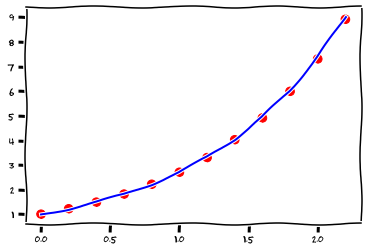

In [143]:
%matplotlib inline
y0 = 1.0
lam = 1
t0, T = 0.0, 2
def f(t, y):
    return lam*y

y_ex = lambda t : y0*np.exp(lam*(t-t0))

Nmax = 10

ts, ys = heuns2alt.solve(y0, t0, T, f, Nmax)
plt.plot(ts, ys, "ro")

plt.plot(ts, y_ex(ts), "b-")

Nmax_list = [4, 8, 16, 32, 64, 128]
errs, eocs = compute_eoc_alt(y0, t0, T, f, Nmax_list, heuns2alt, y_ex)
print(eocs)

# Pretty print
import pandas as pd
from IPython.display import display
eoc_table = pd.DataFrame({'Error':errs, 'EOC':eocs})
display(eoc_table)

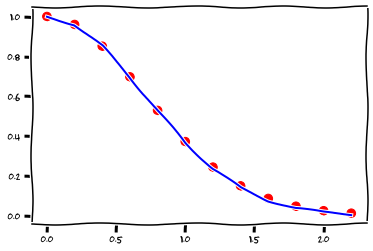

In [144]:
%matplotlib inline
y0 = 1.0
t0, T = 0.0, 2
def f(t, y):
    return -2*y*t

y_ex = lambda t : y0*np.exp(-t**2)

Nmax = 10

ts, ys = heuns2alt.solve(y0, t0, T, f, Nmax)
plt.plot(ts, ys, "ro")

plt.plot(ts, y_ex(ts), "b-")

In [145]:
Nmax_list = [4, 8, 16, 32, 64, 128]
errs, eocs = compute_eoc_alt(y0, t0, T, f, Nmax_list, heuns2alt, y_ex)
print(eocs)

# Pretty print
import pandas as pd
from IPython.display import display
eoc_table = pd.DataFrame({'Error':errs, 'EOC':eocs})
display(eoc_table)

For Nmax =   4, max ||y(t_i) - y_i||= 1.223e-01
For Nmax =   8, max ||y(t_i) - y_i||= 1.609e-02
For Nmax =  16, max ||y(t_i) - y_i||= 3.329e-03
For Nmax =  32, max ||y(t_i) - y_i||= 7.617e-04
For Nmax =  64, max ||y(t_i) - y_i||= 1.830e-04
For Nmax = 128, max ||y(t_i) - y_i||= 4.488e-05
[       inf 2.92609029 2.27300209 2.12805371 2.05748208 2.0275907 ]


,Error,EOC
0,0.122309,inf
1,0.016092,2.926090
2,0.003329,2.273002
3,0.000762,2.128054
4,0.000183,2.057482
5,0.000045,2.027591


### Adding some syntactical sugar to the ExplicitRungeKutta 

Finally, we turn ExplicitRungeKutta class into a "functor", that is class whose
objects can be used like functions. This can be simply achieved by 
using the special class function `__call__`: 

```Python

def __call__(self, ...)

```

In [108]:
# TODO: Show how to replace solve by __call__

def explict_euler(....):
    ...
    ..
    return ts, ys



ts, ys = explicit_euler(y0,  ...)

ts, ys = heun(y0,  ...)

In [146]:
class ExplicitRungeKutta:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
        
    def __call__(self, y0, t0, T, f, Nmax):
        # Extract Butcher table
        a, b, c = self.a, self.b, self.c
        
        # Initiate stages
        s = len(b)
        ks = [np.zeros_like(y0, dtype=np.double) for i in range(s)]
  
        # Start time-stepping
        ys = [y0]
        ts = [t0]
        dt = (T-t0)/Nmax
        
        while(ts[-1] < T):
            t, y = ts[-1], ys[-1]
            
            # Compute stages derivatives k_j
            for j in range(s):
                t_j = t + c[j]*dt
                dY_j = np.zeros_like(y, dtype=np.double)
                for l in range(j):
                    dY_j += a[j,l]*ks[l]
                    
                ks[j] = f(t_j, y + dt*dY_j) 
                
            # Compute next time-step by computing the incremement dy
            dy = np.zeros_like(y, dtype=np.double)
            for j in range(s):
                dy += b[j]*ks[j]
            
            ys.append(y + dt*dy)
            ts.append(t + dt)
            
        return (np.array(ts), np.array(ys))

In [147]:
# Heun
a = np.array([ [0.0, 0],
               [1,   0]])
b = np.array([0.5, 0.5])

c = np.array([0,
              1])

heun = ExplicitRungeKutta(a, b, c)

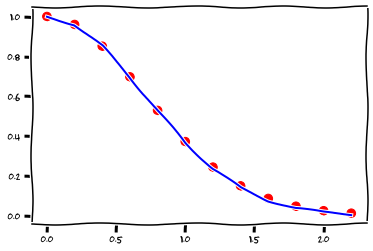

In [149]:
%matplotlib inline
y0 = 1.0
t0, T = 0.0, 2
def f(t, y):
    return -2*y*t

y_ex = lambda t : y0*np.exp(-t**2)

Nmax = 10

ts, ys = heun(y0, t0, T, f, Nmax)
plt.plot(ts, ys, "ro")

plt.plot(ts, y_ex(ts), "b-")

#### Note:

In homework assignment 6 you are asked to implement to 2 specific Runge-Kutta methods.
Here the idea is to mimick/follow the implementation provided in  e.g. the `explicit_euler` or `heun` function provided in `IntroductionNuMeODE.ipynb` rather than to follow the more complicated generalized implementation in `ExplicitRungeKutta` class. For instance, to implement the
the explicit midpoint rule, just have a look at the `heun` function. In fact, you only need to change only a very characters code in 2 code lines to go from Heun to explicit midpoint rule.

## Code tutorial 2: Implementing specific adaptive Runge-Kutta methods

In the second part of the tutorial, we demonstrate how we can e.g. extend the
classical 2nd order Heun's method implemented in the `heun` function to include an automatic error estimation and adaptive time-step selection.  We first recall the Butcher table 
for Heun's method and its implementation:

$$
    \begin{array}{c|cc}
      0 & 0 & 0\\ 1 & 1 &0 \\ \hline & \frac{1}{2} & \frac{1}{2}
    \end{array}
$$

In [221]:
def heun(y0, t0, T, f, Nmax):
    ts = [t0]
    ys = [y0]
    dt = (T-t0)/Nmax
    
    while (ts[-1] < T):
        t, y  = ts[-1], ys[-1]
        k1 = f(t,y)
        k2 = f(t+dt,y+dt*k1)
        ys.append(y + dt*0.5*(k1+k2))
        ts.append(t + dt)
        
    return np.array(ts), np.array(ys)

We quickly check that our implementation is correct by performing convergence rate test using the well-known `compute_eoc` function: 

In [225]:
def compute_eoc(y0, t0, T, f, Nmax_list, solver, y_ex):
    errs = [ ]
    for Nmax in Nmax_list:
        ts, ys = solver(y0, t0, T, f, Nmax)
        ys_ex = y_ex(ts)
        errs.append(np.abs(ys - ys_ex).max())
        print("For Nmax = {:3}, max ||y(t_i) - y_i||= {:.3e}".format(Nmax,errs[-1]))

    errs = np.array(errs)
    Nmax_list = np.array(Nmax_list)
    dts = (T-t0)/Nmax_list

    eocs = np.log(errs[1:]/errs[:-1])/np.log(dts[1:]/dts[:-1])

    # Insert inf at beginning of eoc such that errs and eoc have same length 
    eocs = np.insert(eocs, 0, np.Inf)

    return errs, eocs

Let's run the EOC/convergence rate test:

For Nmax =   4, max ||y(t_i) - y_i||= 1.223e-01
For Nmax =   8, max ||y(t_i) - y_i||= 1.609e-02
For Nmax =  16, max ||y(t_i) - y_i||= 3.329e-03
For Nmax =  32, max ||y(t_i) - y_i||= 7.617e-04
For Nmax =  64, max ||y(t_i) - y_i||= 1.830e-04
For Nmax = 128, max ||y(t_i) - y_i||= 4.488e-05
[       inf 2.92609029 2.27300209 2.12805371 2.05748208 2.0275907 ]


,Error,EOC
0,1.223e-01,inf
1,1.609e-02,2.926e+00
2,3.329e-03,2.273e+00
3,7.617e-04,2.128e+00
4,1.830e-04,2.057e+00
5,4.488e-05,2.028e+00


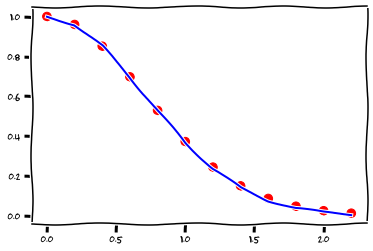

In [227]:
%matplotlib inline
y0 = 1.0
t0, T = 0.0, 2
def f(t, y):
    return -2*y*t

y_ex = lambda t : y0*np.exp(-t**2)

Nmax = 10

ts, ys = heun(y0, t0, T, f, Nmax)
plt.plot(ts, ys, "ro")

plt.plot(ts, y_ex(ts), "b-")

Nmax_list = [4, 8, 16, 32, 64, 128]
errs, eocs = compute_eoc(y0, t0, T, f, Nmax_list, heun, y_ex)
print(eocs)

# Pretty print
import pandas as pd
from IPython.display import display
eoc_table = pd.DataFrame({'Error':errs, 'EOC':eocs})
display(eoc_table)

That's looks good, we get a EOC of around 2 as predicted by the theory we developed.

Next recall, the Heun-Euler pair can be written as

$$
\begin{array}{c|cc} 0 & & \\ 1 & 1 &   \\ \hline & 1 & 0 \\ \hline \displaystyle & \frac{1}{2} &  \frac{1}{2}
 \end{array}
$$

Let's try to implement this in a litte cute function called `euler_heun`:

In [211]:
def euler_heun(y0, t0, T, f, Nmax, tol):
    ts = [t0]
    ys = [y0]
    dt = (T-t0)/Nmax
    # Order for the low order method
    p = 1
    
    # Number of all steps
    N = 0
    
    # Number of rejected steps
    N_rej = 0
    
    while (ts[-1] < T and N < Nmax):
        N += 1
        t, y  = ts[-1], ys[-1]
        k1 = f(t,y)
        k2 = f(t+dt,y+dt*k1)
        
        lerr = norm(dt*0.5*(k1-k2))
        
        if lerr < tol:
            ys.append(y + dt*0.5*(k1+k2))
            ts.append(t + dt)
        else:
            N_rej += 1
        
        dt = min((tol/lerr)**(1/(p+1))*dt, np.abs(T-ts[-1]))
    
    print(f"Completed simulation at t = {ts[-1]} with final T = {T} with {N_rej} rejected steps.")
    return np.array(ts), np.array(ys)

And finally let's test it with one of the analytical test examples above. 

Completed simulation at t = 2.0 with final T = 2 with 4 rejected steps.


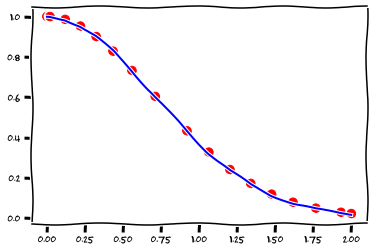

In [212]:
%matplotlib inline
y0 = 1.0
t0, T = 0.0, 2
def f(t, y):
    return -2*y*t

y_ex = lambda t : y0*np.exp(-t**2)

Nmax = 100
tol = 1e-2

ts, ys = euler_heun(y0, t0, T, f, Nmax, tol)
plt.plot(ts, ys, "ro")
plt.plot(ts, y_ex(ts), "b-")

That looks like we succeeded in implemententing error estimation and adaptive time-stepping!

## Afternotes for the second code session 

**1)** One thing we forgot to add during the code tutorial is the extra safety factor in the time-step computation mentioned in the `AdaptiveNuMeODE.ipynb` notebook.
So just add a 

```Python
fac = 0.8
```
at the beginning of the `euler_heun` function and change the computation of the new time-step to

```Python
dt = min(fac*(tol/lerr)**(1/(p+1))*dt, np.abs(T-ts[-1]))
```

If you wish, you can add it as an extra argument in the `__call__` function. For our example with $\mathrm{tol} = 10^{-2}$
and $N_{\mathrm{max}} = 100$ this reduces the number of rejected steps from $4$ to $1$.

**2)** To do a more thorough check of the our implementation, we can use our test case with a known analytical solution to check whether the estimated error is not to far off th actual exact error. That might require to record the computed/estimated error `lerr`. So we change our code **temporary** to store and return also the estimated errorw for those steps which got accepted. This amounts to 3 simple changes in our code.

In [215]:
def euler_heun(y0, t0, T, f, Nmax, tol):
    ts = [t0]
    ys = [y0]
   
    # For storing estimated local errors.
    lerrs = [0]
    
    dt = (T-t0)/Nmax
    # Order for the low order method
    p = 1
    
    # Safety fac
    fac = 0.8
    
    # Number of all steps
    N = 0
    
    # Number of rejected steps
    N_rej = 0
    
    while (ts[-1] < T and N < Nmax):
        N += 1
        t, y  = ts[-1], ys[-1]
        k1 = f(t,y)
        k2 = f(t+dt,y+dt*k1)
        
        lerr = norm(dt*0.5*(k1-k2))
        
        if lerr < tol:
            ys.append(y + dt*0.5*(k1+k2))
            ts.append(t + dt)
            # S
            lerrs.append(lerr)
        else:
            N_rej += 1
        
        dt = min(fac*(tol/lerr)**(1/(p+1))*dt, np.abs(T-ts[-1]))
    
    print(f"Completed simulation at t = {ts[-1]} with final T = {T} with {N_rej} rejected steps.")
    # Also return list of estimated local errors for now
    return np.array(ts), np.array(ys), np.array(lerrs)

Completed simulation at t = 2.0 with final T = 2 with 1 rejected steps.


,Exact errors,Estimated errors
0,0.000e+00,0.000e+00
1,7.999e-08,4.000e-04
2,2.040e-05,6.372e-03
3,3.855e-05,6.135e-03
4,5.135e-05,5.879e-03
5,5.192e-05,5.574e-03
6,2.526e-05,5.161e-03
7,6.635e-05,4.499e-03
8,3.518e-04,3.123e-03
9,1.767e-03,2.126e-03


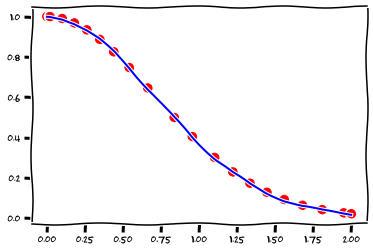

In [219]:
%matplotlib inline

ts, ys, lerrs = euler_heun(y0, t0, T, f, Nmax, tol)

ex_errs = np.abs(ys - y_ex(ts))
plt.plot(ts, ys, "ro")
plt.plot(ts, y_ex(ts), "b-")

pd.options.display.float_format = "{:,.3e}".format
err_table = pd.DataFrame({"Exact errors": ex_errs, "Estimated errors": lerrs})
display(err_table)